- 귀무가설(H0): 이동 거리는 최종 순위에 유의미한 영향을 미치지 않는다.
- 대립가설(H1): 이동 거리는 최종 순위에 유의미한 영향을 미친다.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv(r'C:\Users\ming\Downloads\pubg-finish-placement-prediction\train_V2.csv')

In [16]:
df

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.000,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.040,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.000,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.000,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.000,0,0,49.75,2,0,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,1292.0000,0,0.000,0,0,1019.00,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0.0000,0,0.000,0,0,81.70,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0.0000,0,2.184,0,0,788.70,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,2,0.0000,0,0.000,0,0,2748.00,8,0,0.8000


In [17]:
df = df.dropna()

In [18]:
# 총 이동 거리 계산
df['totalDistance'] = df['walkDistance'] + df['rideDistance'] + df['swimDistance']

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5260\2704415269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['totalDistance'] = df['walkDistance'] + df['rideDistance'] + df['swimDistance']


### 1. 상관관계 확인

               walkDistance  rideDistance  swimDistance  totalDistance  \
walkDistance       1.000000      0.310936      0.167509       0.757859   
rideDistance       0.310936      1.000000      0.049448       0.855586   
swimDistance       0.167509      0.049448      1.000000       0.138718   
totalDistance      0.757859      0.855586      0.138718       1.000000   
winPlacePerc       0.810888      0.342915      0.149607       0.677037   

               winPlacePerc  
walkDistance       0.810888  
rideDistance       0.342915  
swimDistance       0.149607  
totalDistance      0.677037  
winPlacePerc       1.000000  


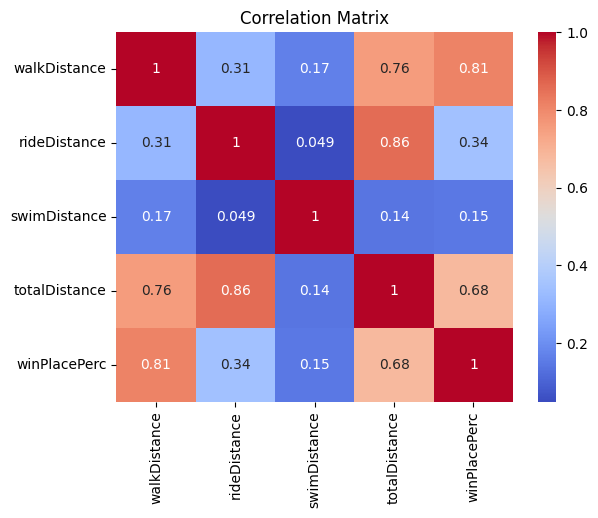

In [19]:
# 상관관계 확인
corr = df[['walkDistance', 'rideDistance', 'swimDistance', 'totalDistance', 'winPlacePerc']].corr()
print(corr)

# 히트맵 시각화
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

- walkDistance와 winPlacePerc 간의 상관계수 0.81은 매우 강한 양의 상관관계

- totalDistance와 winPlacePerc의 상관계수 0.68도 강한 양의 관계

- 단, 상관관계는 인과관계를 보장하지는 않습니다 → 회귀 분석과 ANOVA를 통해 보완함

### 2. 단순 회귀 및 다중 회귀

In [20]:
# (1) 단순 회귀: walkDistance
X = sm.add_constant(df['walkDistance'])
y = df['winPlacePerc']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                 8.538e+06
Date:                Tue, 03 Jun 2025   Prob (F-statistic):               0.00
Time:                        17:52:22   Log-Likelihood:             1.3183e+06
No. Observations:             4446965   AIC:                        -2.637e+06
Df Residuals:                 4446963   BIC:                        -2.637e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2297      0.000   1927.816   

- walkDistance 변수 하나만으로도 winPlacePerc의 약 65.8%에 해당하는 변동성을 설명할 수 있음

In [21]:
# (2) 다중 회귀: walkDistance, rideDistance, swimDistance
model2 = smf.ols('winPlacePerc ~ walkDistance + rideDistance + swimDistance', data=df).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                 2.874e+06
Date:                Tue, 03 Jun 2025   Prob (F-statistic):               0.00
Time:                        17:52:25   Log-Likelihood:             1.3326e+06
No. Observations:             4446965   AIC:                        -2.665e+06
Df Residuals:                 4446961   BIC:                        -2.665e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2147      0.000   1750.027   

- walkDistance, rideDistance, swimDistance는 함께 winPlacePerc의 분산 중 약 66%를 설명 가능

- 각 변수의 p-value <0.05로 모두 통계적으로 유의한 양(+)의 영향을 미침

### 3. 다중공선성 확인 (VIF)

In [22]:
X_vif = df[['walkDistance', 'rideDistance', 'swimDistance']]
X_vif = sm.add_constant(X_vif)
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print('\n[VIF 확인]')
print(vif_data)


[VIF 확인]
        feature       VIF
0         const  1.961466
1  walkDistance  1.136165
2  rideDistance  1.106760
3  swimDistance  1.028640


- 다중공선성 문제 없음

### 4. 이동 거리 수준 그룹화

In [23]:
df['distance_level'] = pd.qcut(df['totalDistance'], q=3, labels=['Low', 'Medium', 'High'])

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5260\237807446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_level'] = pd.qcut(df['totalDistance'], q=3, labels=['Low', 'Medium', 'High'])


In [26]:
# ANOVA 분석
f_val, p_val = stats.f_oneway(low, med, high)
print(f"\n[ANOVA] F-value: {f_val:.3f}, p-value: {p_val:.3e}")


[ANOVA] F-value: 3961468.827, p-value: 0.000e+00


- p < 0.05로 귀무가설 기각, 그룹 간 차이 있음

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5260\2306873652.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='distance_level', y='winPlacePerc', data=df, palette='Set2')


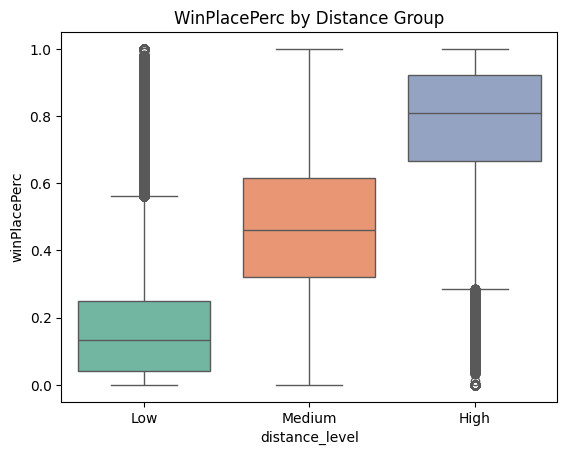

In [27]:
# Boxplot 시각화
sns.boxplot(x='distance_level', y='winPlacePerc', data=df, palette='Set2')
plt.title('WinPlacePerc by Distance Group')
plt.show()

- totalDistance 그룹 간에 winPlacePerc의 평균에 통계적으로 유의한 차이가 있음이 확인됨
- 즉, 플레이어가 더 많이 이동할수록 높은 순위를 기록할 가능성이 크다는 것을 시사함